In [1]:
!git clone https://github.com/ArtemNechaev/stepik_nnets 
!pip install youtokentome

Cloning into 'stepik_nnets'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 195 (delta 96), reused 81 (delta 32), pack-reused 0
Receiving objects: 100% (195/195), 2.41 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (96/96), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.5 MB/s eta 0:00:00a 0:00:010m


In [2]:
import pandas as pd
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from collections import OrderedDict, Counter

from torchtext.data.metrics import bleu_score
from typing import Iterable, List

from stepik_nnets.sec2sec.data import Sec2SecDataset, sequential_transforms, TensorTransform
from stepik_nnets.sec2sec.models import OnlyGRU, Seq2SeqTransformer

from stepik_nnets.sec2sec.engine import train, evaluate, data_to_device
from stepik_nnets.sec2sec.beam_search import  generate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import youtokentome as yttm

import random
import math
import time
from tqdm import tqdm
import pickle
import nltk

import zipfile


In [3]:
SEED = 0


random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

input = '/kaggle/input/title-generation'
output ='/kaggle/working'

train_data_path = "/train_data.txt"
model_path = "/yttm.model"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
df = pd.read_csv(f'{input}/train.csv')
df.to_csv(f'{output}{train_data_path}', header=None, index=None, sep=' ', mode='a')

(array([1.3350e+04, 4.2170e+04, 4.3078e+04, 2.5382e+04, 1.0411e+04,
        5.7600e+02, 1.6000e+01, 1.2000e+01, 1.0000e+00, 4.0000e+00]),
 array([  1. ,  59.3, 117.6, 175.9, 234.2, 292.5, 350.8, 409.1, 467.4,
        525.7, 584. ]),
 <BarContainer object of 10 artists>)

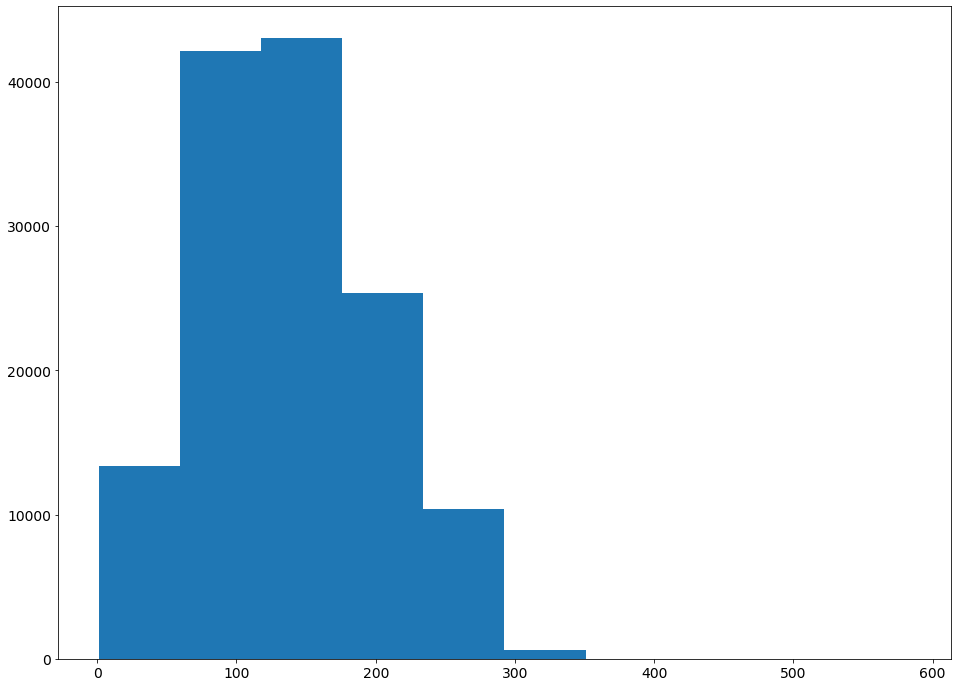

In [5]:
plt.hist(df.abstract.str.split().apply(lambda a: len(a)))

In [6]:
# train test split
_, all = zip(*df.iterrows())
all = list(all)
TRAIN_SPLIT = int(len(all) * 0.95)
np.random.shuffle(all)
train_iter = all[:TRAIN_SPLIT]
val_iter = all[TRAIN_SPLIT:]
all = None


In [7]:
# Training tokenizer
yttm.BPE.train(data=f'{output}{train_data_path}', vocab_size=20000, model=f'{output}{model_path}')

# Loading tokenizer
bpe = yttm.BPE(model=f'{output}{model_path}')

Training parameters
  input: /kaggle/working/train_data.txt
  model: /kaggle/working/yttm.model
  vocab_size: 20000
  n_threads: 2
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 69
number of deleted characters: 0
number of unique characters left: 69
id: 1000=5+182                freq: 12976       subword: eff=e+ff
id: 2000=1101+94              freq: 5056        subword: ▁basis=▁bas+is
id: 3000=8+20                 freq: 2749        subword: af=a+f
id: 4000=10+6                 freq: 1743        subword: nt=n+t
id: 5000=85+455               freq: 1234        subword: enced=en+ced
id: 6000=219+3792             freq: 925         subword: ▁seems=▁se+ems
id: 7000=681+110              freq: 705         subword: ▁valuation=▁valu+ation
id: 8000=1293+27              freq: 562         subword: ▁task,=▁task+,
id: 9000=88+22                freq: 459         subword: ▁pb=▁p+b
id: 10000=329+9008          

In [9]:
from typing import List

SRC_LANGUAGE = 'abs'
TGT_LANGUAGE = 'title'

ln_pair = (SRC_LANGUAGE, TGT_LANGUAGE)

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

transform = sequential_transforms(
    bpe.encode,
    TensorTransform(BOS_IDX, EOS_IDX)
)

text_transform = {}
for ln in ln_pair:
    text_transform[ln] = transform



In [10]:
train_dataset = Sec2SecDataset( train_iter, text_transform, PAD_IDX, ln_pair = ln_pair)
train_iterator = DataLoader(train_dataset, batch_size=128, shuffle = True, collate_fn = train_dataset.pad_collate_fn)

val_dataset = Sec2SecDataset( val_iter, text_transform, PAD_IDX, ln_pair = ln_pair)
valid_iterator = DataLoader(val_dataset, batch_size=128, collate_fn = train_dataset.pad_collate_fn)

In [11]:
#Процент встречаемости слов из заголовка в исходном тексте
res = [sum(1 for t in title if t in a) /len(title) for a, title in  train_dataset]
sum(res)/len(res)

0.7902595520458816

INPUT_DIM = bpe.vocab_size()
OUTPUT_DIM = INPUT_DIM

EMB_SIZE =300
N_HEAD = 2

model = Seq2SeqTransformer(
                 2,
                 2,
                 EMB_SIZE,
                 N_HEAD,
                 INPUT_DIM,
                 OUTPUT_DIM,
                 PAD_IDX,
                 EOS_IDX,
                 device,
                 dim_feedforward = 512,
                 dropout= 0.1).to(device)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [12]:
INPUT_DIM = bpe.vocab_size()
OUTPUT_DIM = INPUT_DIM

EMB_SIZE = 100
HID_SIZE = 80

model = OnlyGRU(INPUT_DIM, OUTPUT_DIM, EMB_SIZE, HID_SIZE, 3,  PAD_IDX, EOS_IDX, device, src_embed = None, trg_embed=None).to(device)

def init_weights(m): 
    for name, param in m.named_parameters(): 
        if 'weight' in name: 
            nn.init.normal_(param.data, mean=0, std=0.01) 
        else: nn.init.constant_(param.data, 0)

model.apply(init_weights)

OnlyGRU(
  (src_embedding): Embedding(20000, 100, padding_idx=1)
  (trg_embedding): Embedding(20000, 100, padding_idx=1)
  (encoder): GRU(100, 80, num_layers=3, bidirectional=True)
  (decoder): GRU(100, 80, num_layers=3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=160, out_features=80, bias=True)
  (enc2dec): Linear(in_features=6, out_features=3, bias=True)
  (to_trg_vocab_size): Linear(in_features=160, out_features=20000, bias=True)
)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {count_parameters(model):,} параметров')

Модель содержит 7,674,021 параметров


In [14]:
optimizer = optim.Adam(model.parameters(), lr=3e-3)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer)


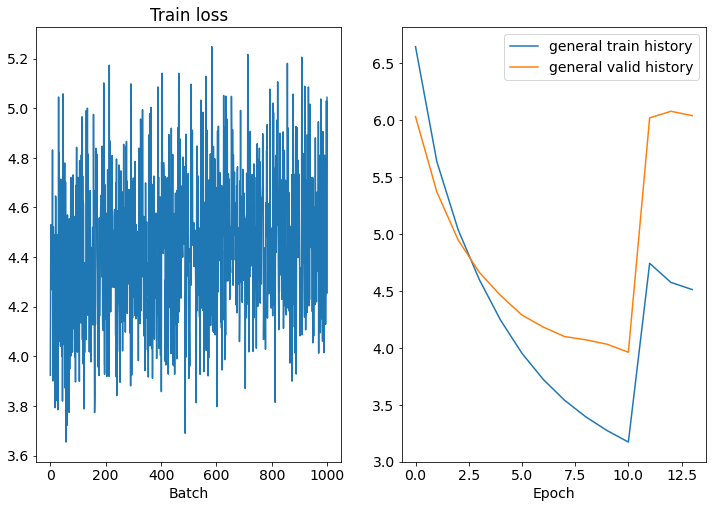

100%|██████████| 15/15 [1:20:42<00:00, 322.84s/it]

	Train Loss: 4.431 | Train PPL:  83.978
	 Val. Loss: 5.889 |  Val. PPL: 361.158


In [15]:

N_EPOCHS = 15
CLIP = float('inf')
best_valid_loss = float('inf')

train_history = []
valid_history = []

model.forward_mode = 'next_word'

try:
    for epoch in tqdm(range(N_EPOCHS)):

        if epoch > 10:
            model.forward_mode = 'greedy'
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history  )
        valid_loss = evaluate(model, valid_iterator, criterion)

        sched.step(valid_loss)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'title-generate_model.pt') 

        train_history.append(train_loss)
        valid_history.append(valid_loss)

        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
except KeyboardInterrupt:
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model.load_state_dict(torch.load('title-generate_model.pt', map_location=device))

## inference

In [16]:

def predict_with_model(model, iterator, vocab,  device = None):
    model.eval()
    device = model.device
    condidate_corpus = []
    ref_corpus = []
    try:
        for batch in iterator:
          with torch.no_grad():
              src, trg = data_to_device(batch, device)
              pred_trg, scores = generate(model,src, beam_size=5, max_len=13, decoder_type = 'rnn')
              pred_trg = pred_trg[:,:,0]

              #pred_trg = model(src, trg, 0)
              #pred_trg = pred_trg.argmax(-1)

              for i in range(src.shape[1]):
                  candidat = pred_trg[:,i][(pred_trg[:,i] != model.eos_idx) & (pred_trg[:,i] != model.pad_idx) ]
                  candidat = vocab.decode([list(candidat.cpu().numpy())])[0].split()

                  ref = trg[1:,i][(trg[1:,i] != model.eos_idx) & (trg[1:,i] != model.pad_idx) ]
                  ref = vocab.decode([list(ref.cpu().numpy())])[0].split()

                  condidate_corpus.append(candidat)
                  ref_corpus.append([ref])
        return condidate_corpus, ref_corpus
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        return condidate_corpus, ref_corpus


In [17]:
condidat_corpus, ref_corpus = predict_with_model(model, valid_iterator, bpe)

In [18]:
bleu_score(condidat_corpus, ref_corpus, max_n=3, weights=[0.34, 0.33, 0.33])

0.07040765695150587

In [19]:
for i in range(10):
    print(' '. join(ref_corpus[i][0]))
    print(' '.join(condidat_corpus[i]) + '\n')
    

microscopic models for welfare measures addressing a reduction of economic inequality
a kinetic model of income dynamics model

the nature of electromagnetic energy
on the electromagnetic energy of electromagnetic energy energy

tracing the jet contribution to the mid-ir over the 2005 outburst of gro j1655-40 via broadband spectral modeling
the x-ray j1655-455-45516

explainable restricted boltzmann machines for collaborative filtering
visualizing the boltzmann machines

randomized opinion dynamics over networks: influence estimation from partial observations
estimation of the estimation in social networks networks

finding the most parsimonious or likely tree in a network with respect to an alignment
the of phylogenetic networks

on idempotent states on quantum groups
quantum quantum group for a quantum group quantum

estimating direction in brain-behavior interactions: proactive and reactive brain states in driving
brain-based brain activity in brain brain brain

the hexatangle
surge

In [20]:
submission_data = pd.read_csv('/kaggle/input/title-generation/test.csv')
abstracts = submission_data['abstract'].values
test_iter = [(a, 'a') for a in abstracts]
test_dataset = Sec2SecDataset( test_iter, text_transform, PAD_IDX, ln_pair = ln_pair)
test_iterator = DataLoader(test_dataset, batch_size=30, collate_fn = test_dataset.pad_collate_fn)

test_preds, _ = predict_with_model(model, test_iterator, bpe)

In [21]:

titles = []
for t_pred in test_preds:

    #title, _ = translate_sentence(model, abstract.split())
    titles.append(' '.join(t_pred).replace('<unk>', ''))
    
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

In [22]:
import string
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='/kaggle/input/title-generation/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        try:
            trg = row['title']
            trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
            if len(trg) < 2:
                trg *= 2
            trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])

            VOCAB_stoi = vocs[row_idx]
            trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
            trg_vec = np.zeros(len(VOCAB_stoi))    

            for word in trg_intersection:
                trg_vec[VOCAB_stoi[word]] = 1

            with open(output_file, 'a') as res_file:
                for is_word in trg_vec:
                    res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                    output_idx += 1
        except:
            continue


generate_csv()